## Sagnac Frequency - Backscatter Correction - RU shortterm

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [4]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

# hardly jumps or splits
# config['tbeg'] = UTCDateTime("2024-03-26 12:00")
# config['tend'] = UTCDateTime("2024-03-31 00:00")
# flim1, flim2 = 302.42, 302.50

# splits
# config['tbeg'] = UTCDateTime("2024-03-26 12:00")
# config['tend'] = UTCDateTime("2024-03-30 21:00")
# flim1, flim2 = 302.40, 302.50

#
# config['tbeg'] = UTCDateTime("2024-03-31 18:00")
# config['tend'] = UTCDateTime("2024-04-03 00:00")
# flim1, flim2 = 302.42, 302.50

# config['tbeg'] = UTCDateTime("2024-04-20 18:00")
# config['tend'] = UTCDateTime("2024-04-30 00:00")
# flim1, flim2 = 302.41, 302.49

config['tbeg'] = UTCDateTime("2024-04-01 00:00")
config['tend'] = UTCDateTime("2024-04-20 00:00")
flim1, flim2 = 302.41, 302.49



## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Configurations

In [5]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [6]:
from functions.backscatter_correction import __backscatter_correction

In [7]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, bs.fj_fs, np.median(bs.fj_fs), cm_filter_factor=1.033)

(302.41, 302.49)

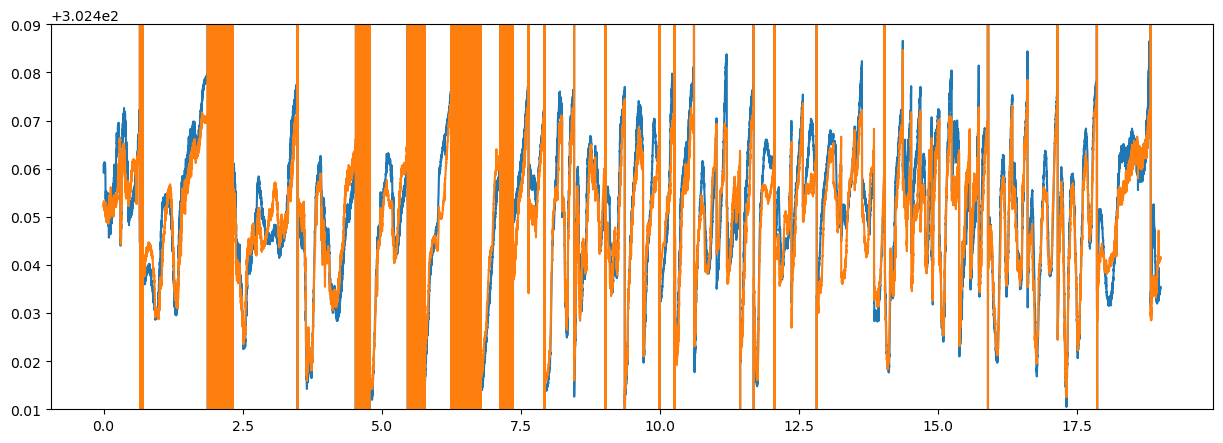

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.plot(bs.time_sec/86400, bs.fj_bs)

# plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [9]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [10]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [11]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [12]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)

### Apply special filter sections

In [13]:
tt1, tt2 = "2023-11-01", "2023-11-07 17:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.95
cond4 = bs.fj_fs_nan > 303.1

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [14]:
tt1, tt2 = "2023-11-07 17:00", "2023-11-20 14:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.7
cond4 = bs.fj_fs_nan > 303.0

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [15]:
tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.4
cond4 = bs.fj_fs_nan > 302.6

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [16]:
tt1, tt2 = "2023-12-20 00:00", "2024-02-22"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.38
cond4 = bs.fj_fs_nan > 302.48

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [17]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [18]:
from functions.smoothing import __smooth

n_minutes = 300

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [19]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [20]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Checkup Plot

/tmp/ipykernel_2781188/3069509830.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


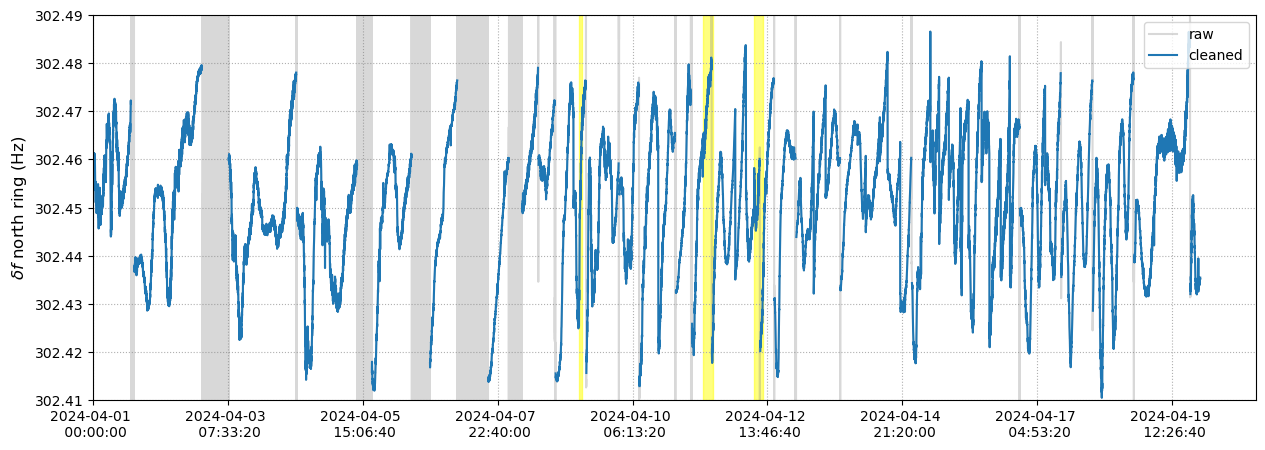

In [21]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Load WROMY Data

In [22]:
ws = Stream()
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

ws = ws.merge();

ws

3 Trace(s) in Stream:
BW.WROMY.01.LKI | 2024-04-01T00:00:00.000000Z - 2024-04-20T00:00:00.000000Z | 1.0 Hz, 1641601 samples
BW.WROMY.05.LKI | 2024-04-01T00:00:00.000000Z - 2024-04-20T00:00:00.000000Z | 1.0 Hz, 1641601 samples
BW.WROMY.09.LKI | 2024-04-01T00:00:00.000000Z - 2024-04-20T00:00:00.000000Z | 1.0 Hz, 1641601 samples

### Load PROMY Data

In [23]:
ps = Stream()
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps3 = ps.merge();

ps

4 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-04-01T00:00:00.000000Z - 2024-04-20T00:00:00.000000Z | 1.0 Hz, 1641601 samples
BW.PROMY.03.LKI | 2024-04-01T00:00:00.000000Z - 2024-04-20T00:00:00.000000Z | 1.0 Hz, 1641601 samples
BW.PROMY.05.LKI | 2024-04-01T00:00:00.000000Z - 2024-04-20T00:00:00.000000Z | 1.0 Hz, 1641601 samples
BW.PROMY.09.LKI | 2024-04-01T00:00:00.000000Z - 2024-04-20T00:00:00.000000Z | 1.0 Hz, 1641601 samples

### Load Rain Data

In [24]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [25]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

/home/andbro/andbro_python/andbro__load_FURT_stream.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="ignore")


In [26]:
rain = furt.select(channel="LAR")

# smoothed precipitation
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)

# cumulative rain
rain_cumsum = np.nancumsum(rain[0].data)

### Load Tilt Data

In [27]:
from functions.conversion_to_tilt import __conversion_to_tilt

In [28]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

tromy0 =  __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

  -> converted data of ROMYT


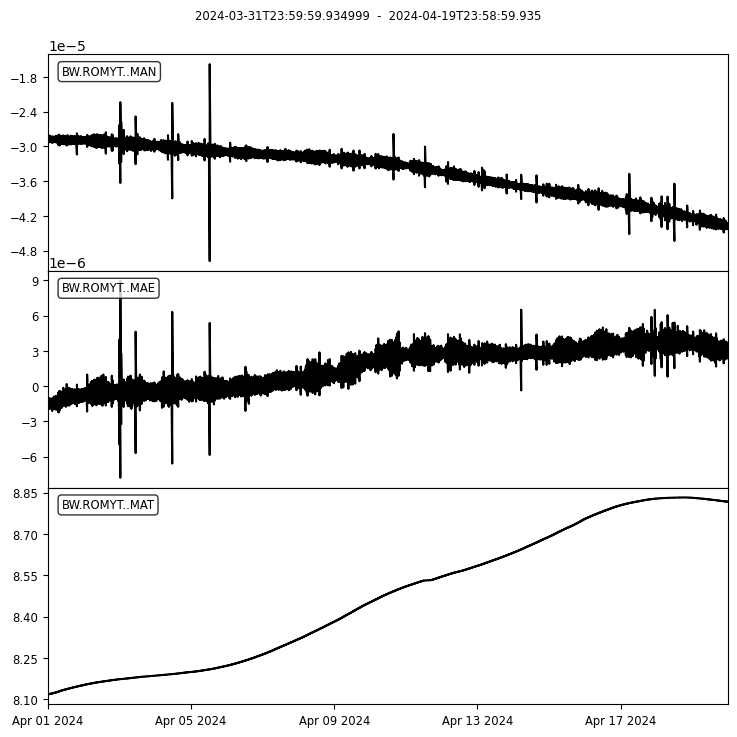

In [29]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

tromy0 = tromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

tromy = tromy0.copy();

tromy = tromy.merge();

tromy.plot(equal_scale=False);

del tromy0

In [30]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
# # path_to_tilt = archive_path+"romy_archive/"

# bromy0 =  __read_sds(path_to_tilt, "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
# bromy0 += __read_sds(path_to_tilt, "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)


In [31]:
# ## tiltmeter configurations
# confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

# bromy0 = __conversion_to_tilt(bromy0, confTilt['BROMY'])

# bromy0 = bromy0.trim(bs.time1[0], bs.time1[bs.time1.size-1]);

# # bromy0 = bromy0.filter("lowpass", freq=0.5, corners=4, zerophase=True)
# # bromy0 = bromy0.resample(1.0)

# bromy = bromy0.copy();

# bromy = bromy.merge(fill_value="interpolate");

# bromy.plot(equal_scale=False);

# del bromy0;

### Load Water Level Data

In [32]:
from functions.load_water_level import __load_water_level

In [33]:
try:
    pegel =  __load_water_level(config['tbeg'], config['tend'], path_to_data=root_path+"lamont/Pegel/")

    ## remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

    pegel

except:
    pass

### Load Beam Wander Data

In [34]:
from functions.load_beam_wander_data import __load_beam_wander_data

In [35]:
bw = __load_beam_wander_data(config['tbeg'].date, config['tend'].date, data_path+"ids/data/")

2024-04-01
2024-04-02
2024-04-03
2024-04-04
2024-04-05
2024-04-06
2024-04-07
2024-04-08
2024-04-09
2024-04-10
2024-04-11
2024-04-12
2024-04-13
2024-04-14
2024-04-15
2024-04-16
2024-04-17
2024-04-18
2024-04-19
2024-04-20


In [36]:
bw = bw[(bw.time > config['tbeg']) & (bw.time < config['tend'])]

bw['time_utc'] = np.array([UTCDateTime(_t) for _t in bw.time])

bw['x_mm'] = bw.x*1.67e-3
bw['y_mm'] = bw.y*1.67e-3

bw['x_mm'] = __reduce(bw.x_mm, 100)
bw['y_mm'] = __reduce(bw.y_mm, 100)

bw = bw[bw.amp > 10]

In [37]:
gc.collect()

0

### Load Infrasound FFBI

In [38]:
ffbi = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])


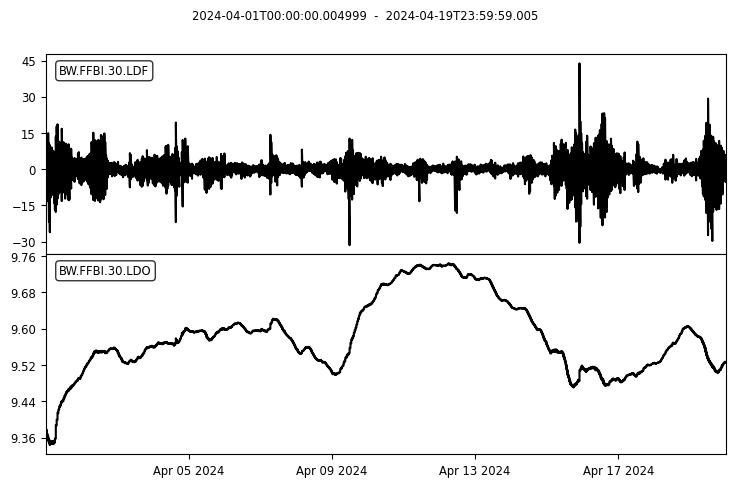

In [39]:
ffbi.plot(equal_scale=False);

In [40]:
# ffbi = __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDF", config['tbeg'], config['tend'])

# if len(ffbi) != 2:
#     ffbi.merge();

# ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")
# ffbi = ffbi.remove_response(ffbi_inv, water_level=10)

# ffbi += __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDO", config['tbeg'], config['tend'])
# for tr in ffbi:
#     if "O" in tr.stats.channel:
#         tr.data = tr.data /1.0 /6.28099e5 /100e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa

#     ffbi = ffbi.resample(1.0, no_filter=True)

# ffbi.merge(fill_value="interpolate")

# ffbi.plot(equal_scale=False);

## Plotting

In [41]:
ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

In [42]:
# bromyN_smooth = __reduce(bromy.select(channel="*N")[0].data, 100)
# bromyE_smooth = __reduce(bromy.select(channel="*E")[0].data, 100)

In [43]:
tromyN_smooth = __smooth(__reduce(tromy.select(channel="*N")[0].data, 100), int(20*tromy.select(channel="*N")[0].stats.sampling_rate))
tromyE_smooth = __smooth(__reduce(tromy.select(channel="*E")[0].data, 100), int(20*tromy.select(channel="*E")[0].stats.sampling_rate))

In [ ]:
def __makeplot():

    Nrow, Ncol = 6, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    ref_date = bs.time1.iloc[0]

    # _____________________________________________________________________________________
    #
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="black", label="cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="red", label=f"BS corrected")

    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    # _____________________________________________________________________________________
    #
    for tr in ws.select(channel="*T"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=UTCDateTime(ref_date)),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"WS{num}", alpha=0.7)

    for tr in ps.select(channel="*KI"):
        num = int(tr.stats.location[-1])
        if num != 1:
            ax[1].plot(tr.times(reftime=UTCDateTime(ref_date)),
                       __smooth(tr.data, 600), color=config['colors'][num], label=f"PS{num}", alpha=0.7)

    # ax[1].set_ylim(10.5, 11)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.plot(ps.select(location="01", channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
              __smooth(ps.select(location="01", channel="*KI")[0].data, 600), color=config['colors'][1], label="PS1")

    ax11.set_ylabel("Temperature (°C)", fontsize=font, color=config['colors'][1])
    [t.set_color(config['colors'][1]) for t in ax11.yaxis.get_ticklabels()]
    ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))



    # _____________________________________________________________________________________
    #
    try:
        ax[2].plot(pegel.times_utc - UTCDateTime(ref_date), pegel.pegel, color="purple", alpha=0.9, zorder=3)
    except:
        pass

    ax[2].set_ylabel(f"Water Level (m)", fontsize=font, color="purple")
    # ax[2].set_zorder(3)
    [t.set_color("purple") for t in ax[2].yaxis.get_ticklabels()]

    ax22 = ax[2].twinx()
    ax22.fill_between(rain[0].times(reftime=UTCDateTime(ref_date)),
                      __interpolate_nan(rain[0].data), color="tab:blue", alpha=0.6, label=f"rain", zorder=0)

    ax22.set_ylim(bottom=0)
    ax22.set_ylabel(f"Precipitation \n (mm/s)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax22.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_zorder(1)


    ax24 = ax[2].twinx()
    ax24.plot(rain_cumsum/max(rain_cumsum)*100, alpha=0.9, zorder=1, ls="--", color="darkblue")

    # ax24.axis('off')
    ax24.set_zorder(1)
    ax24.spines.right.set_position(("axes", 1.12))

    # ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    # [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]
    ax24.set_ylabel(f"Cum. Rain (%)", fontsize=font, color="darkblue")
    [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]


    # _____________________________________________________________________________________
    #
    ax[3].plot(tromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date))[:-20],
               tromyN_smooth[:-20]*1e6,
               label=f"T{tromy[0].stats.station} N-S (20 sec. avg.)", color="tab:orange")
    ax[3].plot(tromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date))[:-20],
               tromyE_smooth[:-20]*1e6,
               label=f"T{tromy[0].stats.station} E-W (20 sec. avg.)", color="tab:brown")

    # ax[3].plot(bromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date))[:-20],
    #            bromyN_smooth[:-20]*1e6,
    #            label=f"T{bromy[0].stats.station} N-S (20 sec. avg.)", color="tab:red")
    # ax[3].plot(bromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date))[:-20],
    #            bromyE_smooth[:-20]*1e6,
    #            label=f"T{bromy[0].stats.station} E-W (20 sec. avg.)", color="tab:blue")

    ax[3].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    # ax[3].set_ylim(-5, 5)

    # _____________________________________________________________________________________
    #
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi_bdf_smooth1,
               label=f"{ffbi.select(channel='*F')[0].stats.station}.{ffbi.select(channel='*F')[0].stats.channel} (1 min. avg.)",
               color="tab:red"
              )
    ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=UTCDateTime(ref_date)),
               ffbi_bdf_smooth2,
               color="white", ls="-", lw=1,
              )

    ax[4].set_ylabel("Differential \n Pressure (Pa)", fontsize=font)
    # ax[4].set_ylim(-, 6)

    ax41 = ax[4].twinx()
    ax41.plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date)),
              ffbi.select(channel="*O")[0].data*100,
              color="darkred"
              )
    ax41.set_ylabel("Pressure (hPa)", fontsize=font, color="darkred")
    [t.set_color('darkred') for t in ax41.yaxis.get_ticklabels()]

#     # _____________________________________________________________________________________
#     #
    ax[5].scatter(bw.time_utc - UTCDateTime(ref_date),
                  bw.x_mm*1e3,
                  label=f"in-plane",
                  color="tab:pink",
                  zorder=2,
                  s=5,
              )
    ax[5].scatter(bw.time_utc - UTCDateTime(ref_date),
                  bw.y_mm*1e3,
                  label=f"out-of-plane",
                  color="purple",
                  zorder=2,
                  s=5,
              )

    ax[5].set_ylabel("rel. Beam \n Position ($\mu$m)", fontsize=font)
    ax[5].set_ylim(-150, 150)


    # _____________________________________________________________________________________
    #
    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, alpha=0.5)


    ax[0].legend(loc=1, ncol=3)
    ax[1].legend(loc=1, ncol=1)
    ax11.legend(loc=4, ncol=1)
    ax[3].legend(loc=8, ncol=1)
    ax[4].legend(loc=1, ncol=1)
    ax[5].legend(loc=9, ncol=2)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add maintenance
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)


    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_environmentals_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')

del fig

In [45]:
## prepare Hilbert transform of pressure

In [46]:
p = ffbi.select(channel="*DO")[0].data

NN = int(1e6)
px = np.pad(p, (NN, NN), mode="constant")

hp_data = np.imag(hilbert(px))

hp = hp_data[NN:-NN]

# plt.plot(p)
# plt.plot(hp)

## Define Dataframe

In [47]:

df = DataFrame()

reftime = bs.time1.iloc[0]

df['time'] = bs.time_sec

df['fj_bs'] = __reduce(bs.fj_bs_inter, 10)

ps3_data = __reduce(__interpolate_nan(ps.select(location="03")[0].data), 100)
df['ps3'] = np.interp(df.time, ps.select(location="03")[0].times(reftime=reftime), ps3_data)

ps1_data = __reduce(__interpolate_nan(__smooth(ps.select(location="01")[0].data, 1800)), 100)
df['ps1'] = np.interp(df.time, ps.select(location="01")[0].times(reftime=reftime), ps1_data)

ps5_data = __reduce(__interpolate_nan(__smooth(ps.select(location="05")[0].data, 1800)), 100)
df['ps5'] = np.interp(df.time, ps.select(location="05")[0].times(reftime=reftime), ps5_data)

ps9_data = __reduce(__interpolate_nan(__smooth(ps.select(location="09")[0].data, 1800)), 100)
df['ps9'] = np.interp(df.time, ps.select(location="09")[0].times(reftime=reftime), ps9_data)

bdo_data = __reduce(ffbi.select(channel="*DO")[0].data, 100)
df['bdo'] = np.interp(df.time, ffbi.select(channel="*DO")[0].times(reftime=reftime), bdo_data)

hp_data = hp
df['hp'] = np.interp(df.time, ffbi.select(channel="*DO")[0].times(reftime=reftime), hp_data)


bdf_data = __reduce(__interpolate_nan(__smooth(ffbi.select(channel="*DF")[0].data, 600)), 100)
df['bdf'] = np.interp(df.time, ffbi.select(channel="*DF")[0].times(reftime=reftime), bdf_data)

man_data = __reduce(__interpolate_nan(__smooth(tromy.select(channel="MAN")[0].data, 5*60)), 100)
df['man'] = np.interp(df.time, tromy.select(channel="MAN")[0].times(reftime=reftime), man_data)

mae_data = __reduce(__interpolate_nan(__smooth(tromy.select(channel="MAE")[0].data, 5*60)),100)
df['mae'] = np.interp(df.time, tromy.select(channel="MAE")[0].times(reftime=reftime), mae_data)

try:
    peg_data = __reduce(__interpolate_nan(__smooth(pegel.pegel, 20)), 100)
    df['peg'] = np.interp(df.time, pegel.times_utc - bs.time1.iloc[0], peg_data)
except:
    pass

bwx = bw.x_mm
bwx = np.where((abs(np.diff(bwx, prepend=0)) > 0.001), np.nan, bwx)
bwx = np.where((abs(bwx) > 0.1), np.nan, bwx)

df['bwx'] = np.interp(df.time, np.array(bw.time_utc - bs.time1.iloc[0], dtype=float), __interpolate_nan(__smooth(__interpolate_nan(bwx), 10)))

bwy = bw.y_mm
bwy = np.where((abs(np.diff(bwy, prepend=0)) > 0.001), np.nan, bwy)
bwy = np.where((abs(bwy) > 0.1), np.nan, bwy)

df['bwy'] = np.interp(df.time, np.array(bw.time_utc - bs.time1.iloc[0], dtype=float), __interpolate_nan(__smooth(__interpolate_nan(bwy), 10)))


In [48]:
df.to_pickle(config['path_to_out_data']+"multi_regression_RU_df1.pkl")

time


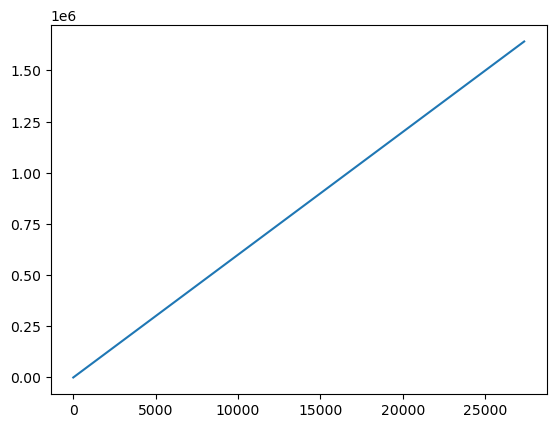

fj_bs


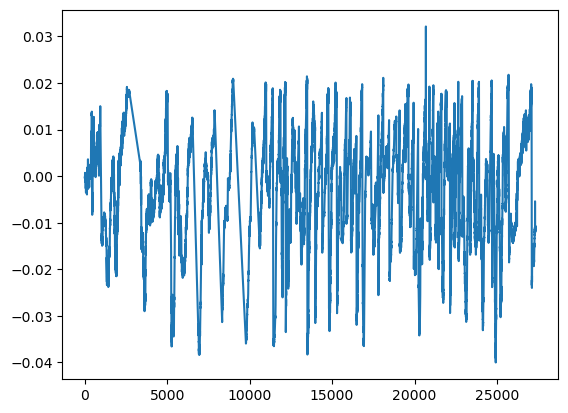

ps3


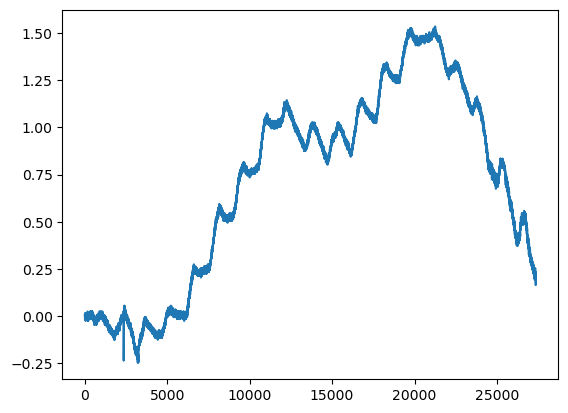

ps1


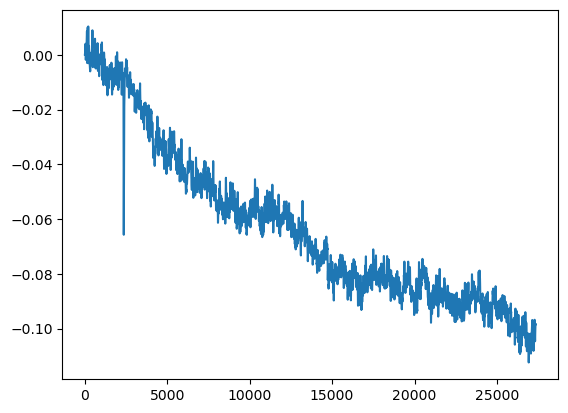

ps5


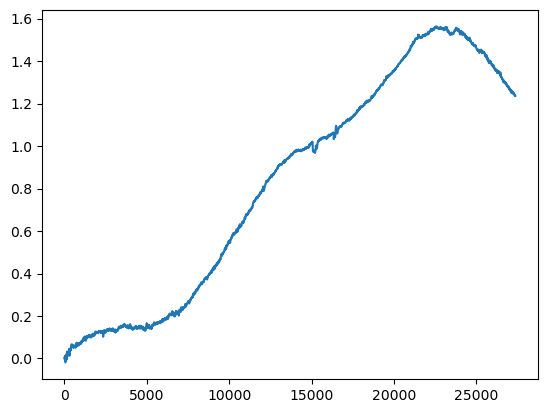

ps9


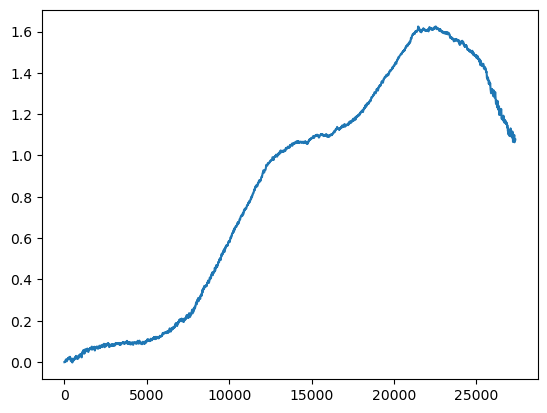

bdo


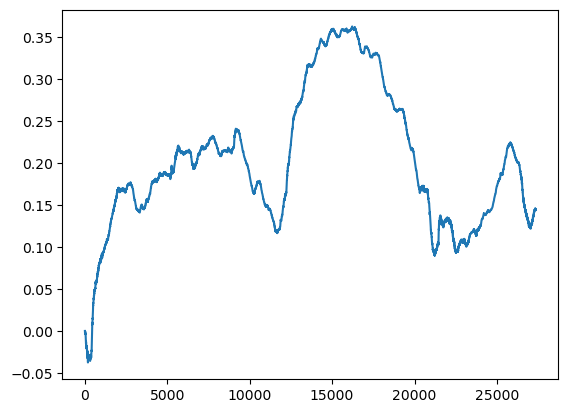

hp


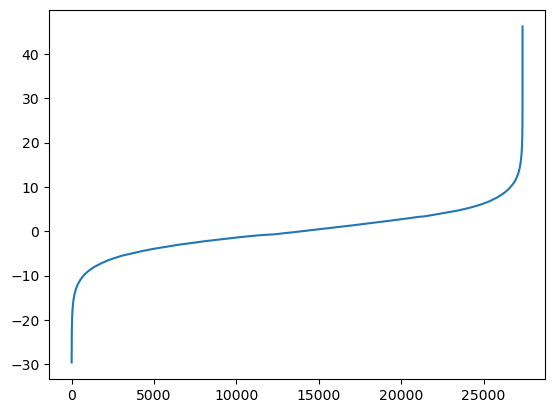

bdf


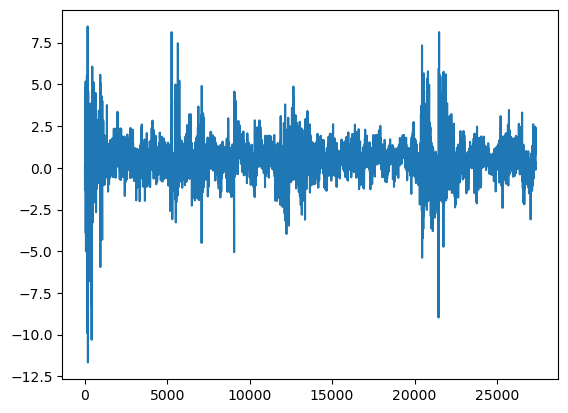

man


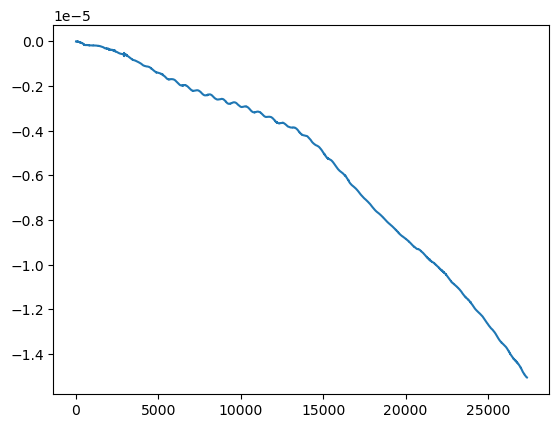

mae


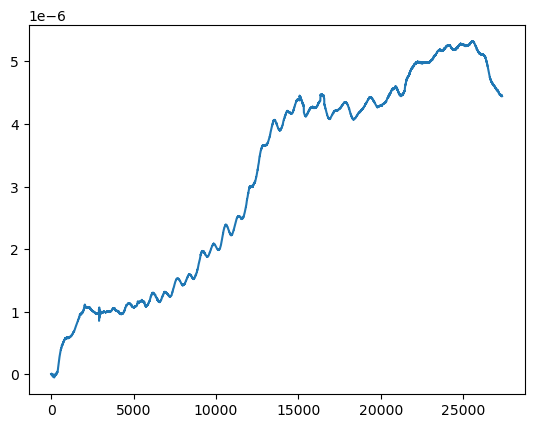

peg


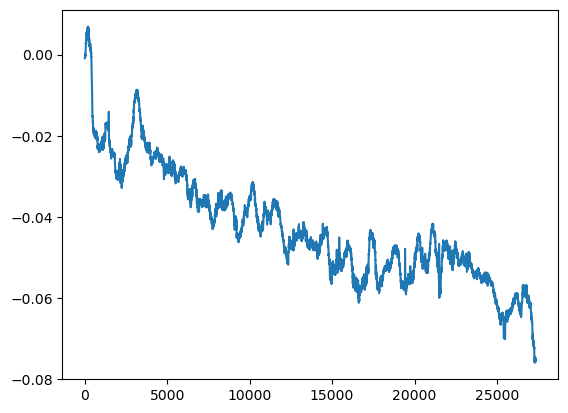

bwx


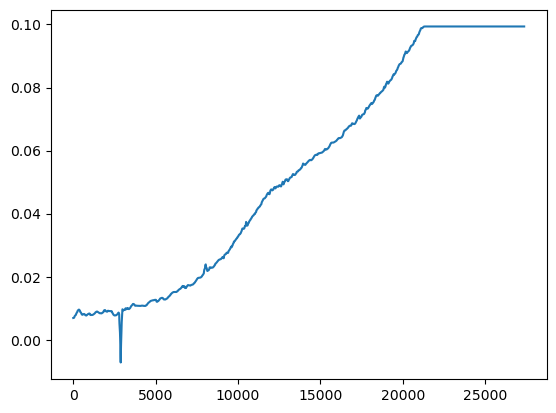

bwy


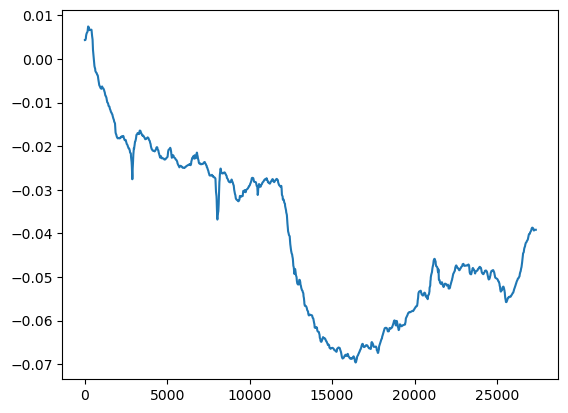

In [49]:
for k in df.keys():
    plt.figure()
    print(k)
    plt.plot(df[k])
    plt.show();